## Research notebook
This notebook develops the main ideas and parts of our SMOTE oversampling strategy. 

In [32]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

## Load in data 

Load in the positive dataset and the lookback vector of the negatives

In [3]:
pos = pd.read_csv("data/pos_data.csv")
neg_lookback = pd.read_csv("data/neg_lookback.csv", header=None)

## Define SMOTE that can handle missing values

For an explanation see the doc-string of `SMOTE_missng`.

In [94]:
def SMOTE_missing(df, upsample=2, p=1, verbose=True):
    """
    This function takes in a dataframe, finds its columns
    which are full, i.e. without missing values and 
    standardises them. Then it uses these full columns
    to find the nearest neighbours, like the original SMOTE.
    
    However, when it generates new samples it uses the 
    full sample vector. So if the closest neighbour of 
    sample i has missing values, those will be used for
    creating a new synthetic data point. The non-missing
    values will be multiplied by a random number like in
    the default SMOTE.
    
    The upsample param sets the number of new synthetic 
    positives we want to generate for each positive sample.
    
    The p param sets the power of the minkowski distace,
    where p = 1 is Manhattan, p=2 is Euclidean distance.
    """
    
    full_cols = df.columns[pd.isnull(df).sum() == 0]
    full_df = df[full_cols]
    
    # standardise the full columns - this is for NN calculation
    ss = StandardScaler()
    X = ss.fit_transform(full_df.values)
    n, _ = X.shape
    
    # find nearest neighbours
    neigh = NearestNeighbors(algorithm='auto', p=p, n_jobs=-1)
    neigh.fit(X)

    # for each positive sample find the k nearest neighbours, 
    # where k = upsample, i.e. the number of new synthetic 
    # samples we want to generate for each positive sample
    nearest_neighs = []
    row_ix = []
    for i in range(n):
        if verbose and i % 25 == 0:
            print("Upsampling positive sample #", i)
        # closest sample by default is the sample itself
        nns = neigh.kneighbors(X[i,:].reshape(1,-1), upsample+1, 
                               return_distance=False)
        nearest_neighs += list(nns.ravel())[1:]
        row_ix += [i] * upsample

    # SMOTE: take the difference between each sample and its 
    # nearest neighbours and multiply this diff vector by a 
    # random number on the range of [0, 1]
    original_samples = df.iloc[row_ix, :].values
    nearest_samples = df.iloc[nearest_neighs,:].values
    diff_matrix =   nearest_samples - original_samples
    random_weights = np.random.rand(n * upsample)
    random_diff = diff_matrix * random_weights[:, np.newaxis]
    new_samples = original_samples + random_diff
    return pd.DataFrame(new_samples, columns=df.columns)


def hack_for_binary_flags(df, cols, thresh=0.5):
    """
    We don't have a good solution for sythetic categorical vars.
    This hacky solution will turn binary flag columns in a 
    sythetic dataset into zeros and ones. 
    """
    binary_cols = df[cols].copy(deep=True)
    binary_cols[binary_cols >= thresh] = 1
    binary_cols[binary_cols < thresh] = 0
    df.update(binary_cols)
    return df

## Apply `SMOTE_missing` on a sample

Then compare the lookback dist of the sample and the synthetic data

In [95]:
pos_sample = pos.iloc[0:100,:]
pos_sample_SMOTE = SMOTE_missing(pos_sample, upsample=3)

Upsampling positive sample # 0
Upsampling positive sample # 25
Upsampling positive sample # 50
Upsampling positive sample # 75


In [87]:
pos_sample_SMOTE = hack_for_binary_flags(pos_sample_SMOTE, ["GENDER"])
pos_sample_SMOTE.head()

,LOOKBACK,AGE,GENDER,D_7373_AVG_CLAIM_CNT,D_7803_AVG_CLAIM_CNT,D_7809_AVG_CLAIM_CNT,D_7840_AVG_CLAIM_CNT,D_7865_AVG_CLAIM_CNT,D_7931_AVG_CLAIM_CNT,D_4659_AVG_CLAIM_CNT,...,S_S83_LAST_EXP_,S_S02_LAST_EXP_,S_S42_LAST_EXP_,S_S30_LAST_EXP_,S_S12_LAST_EXP_,S_S29_LAST_EXP_,S_S57_LAST_EXP_,S_S14_LAST_EXP_,S_S59_LAST_EXP_,S_S11_LAST_EXP_
0,833.784210,82.044971,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1203.447414,71.600143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,911.855457,73.913272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1611.491095,56.066763,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1367.180425,59.396833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


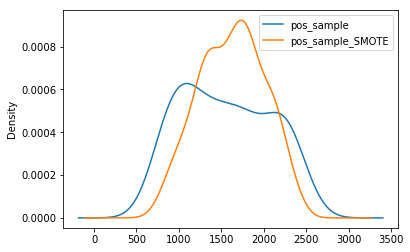

In [96]:
def plot_lookbacks(l1, l2, label1, label2):
    to_plot = pd.concat([l1, l2], axis=1)
    to_plot.columns = [label1, label2]
    to_plot.plot(kind="kde")
plot_lookbacks(pos_sample.LOOKBACK, pos_sample_SMOTE.LOOKBACK, "pos_sample", "pos_sample_SMOTE")

They are not from the same distribution as the KS test cannot be rejected.

In [98]:
real = pos_sample.LOOKBACK.values
smote = pos_sample_SMOTE.LOOKBACK.values
sp.stats.ks_2samp(real, smote)

Ks_2sampResult(statistic=0.20666666666666664, pvalue=0.002708491623291428)

## Approximate the two lookback distributions

Try to throw away indices from sythetic lookback so it looks more similar to the sample lookback distrinution

In [47]:
def approximate_lookbacks(pos_real, pos_smote, neg, bin_width=30):
    """
    Given three lists of lookbacks (in days), this function will
    define the positive lookback as {pos_real U pos_smote}, then
    bin both neg and the pos lookback lists to common bins. See
    bin_width (by default we bin days to months). 
    
    If there are months where we have more synthetic data (as
    density) we discard samples until that's not the case. 
    
    The lookback of the positives is not touched, we only
    discard smote positive samples to approximate the 
    lookback of the 
    
    pos_real: lookback of the positives
    pos_smote: lookback of the synthetic positives
    neg: lookback of the negatives
    bin_width: number of days to use for binning
    """
    # merge pos_real and pos_smote
    pos = list(pos_real) + list(pos_smote)
    
    # record length of lists
    pos_real_n = len(list(pos_real))
    pos_n = len(list(pos))
    neg_n = len(list(neg))
    
    # find the min and max of the real and synthetic lookbacks
    min_d = np.min([np.min(pos), np.min(neg)])
    max_d = np.max([np.max(pos), np.max(neg)])

    # define bins for histogram, by default we use months
    bins = np.arange(min_d, max_d, bin_width)

    # bin lookback days into months
    pos_m = np.digitize(pos, bins)
    neg_m = np.digitize(neg, bins)

    # these will help to keep track of all the sythetic samples 
    # we need to discard
    pos_ix = np.arange(pos_n)
    to_delete = []
    to_delete_n_old = 0

    # get histogram of lookback in months
    pos_h = np.bincount(pos_m, minlength=bins.size + 1)/pos_n
    neg_h = np.bincount(neg_m, minlength=bins.size + 1)/neg_n

    # subtract real histogram from synthetic
    h_diff = pos_h - neg_h

    # until we have more frequent months in sythetic data
    while np.any(h_diff > 0):
        # bins that are higher in smote than real
        pos_higher_ix = np.where(h_diff > 0)[0]
        for bin_ix in pos_higher_ix:
            # samples that are in the examined bin
            ix_in_bin = np.where(pos_m == bin_ix)[0]
            
            # check if we have smote samples in this bin
            if np.any(pos_ix[ix_in_bin] >= pos_real_n):
                # use only the smote samples
                ix_in_bin = ix_in_bin[np.where(pos_ix[ix_in_bin] >= pos_real_n)[0]]
                # choose one randomly 
                ix_to_delete = np.random.choice(ix_in_bin)
                # add it to output vector
                to_delete.append(pos_ix[ix_to_delete])
                
                # delete it from both pos_m and pos_ix to update the distribution
                pos_m = np.delete(pos_m, ix_to_delete)
                pos_ix = np.delete(pos_ix, ix_to_delete)
                # update histogram and hist diff
                pos_h = np.bincount(pos_m, minlength=bins.size + 1)/pos_n
                h_diff = pos_h - neg_h

        # check if are we still making progress, if not, stop
        if len(to_delete) == to_delete_n_old:
            break
        to_delete_n_old = len(to_delete)

    return to_delete

Original distributions

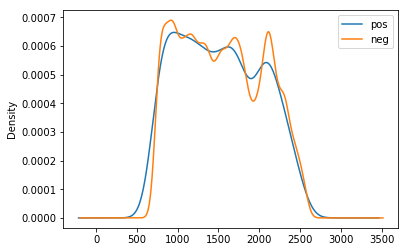

In [65]:
plot_lookbacks(pos.LOOKBACK, neg_lookback, "pos", "neg")

In [92]:
sp.stats.ks_2samp(neg_lookback.values.ravel(), pos.LOOKBACK)

Ks_2sampResult(statistic=0.037990985189954925, pvalue=0.024002403631348895)

Try the `approximate_lookbacks` and see if smote samples are making the lookback distributions more similar

In [99]:
to_delete = approximate_lookbacks(pos.LOOKBACK, pos_sample_SMOTE.LOOKBACK, neg_lookback.values.ravel())
pos_lookback = pd.concat([pos.LOOKBACK, pos_sample_SMOTE.LOOKBACK])
pos_lookback.index = np.arange(pos_lookback.shape[0])
pos_lookback.drop(to_delete, inplace=True)

Updated after one round

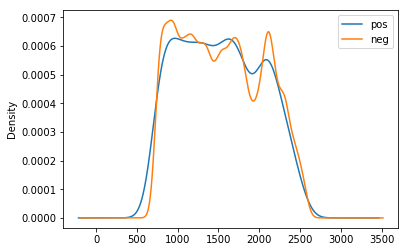

In [100]:
plot_lookbacks(pos_lookback, neg_lookback, "pos", "neg")

In [101]:
sp.stats.ks_2samp(neg_lookback.values.ravel(), pos_lookback)

Ks_2sampResult(statistic=0.035435761025418899, pvalue=0.027612652939727589)